In [26]:
import pandas as pd
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [27]:
# Calculate the fair price of c_0 so that we do not need to
S_0=95
K=105
sigma = 0.15
T=1
r = 0
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Global variable
c_0 = black_scholes_call(S_0, K, T, r, sigma)


In [14]:
# Reblancing the final result
def Rebalancing(N,c_0):
   
    # Given constants
    S_0=95
    K=105
    sigma = 0.15
    T=1
    r = 0
    n = 80000
    dt = T/N
    
    res = []
    for i in range(n):
        path = [S_0]
        delta = 0
        B = c_0
        for j in range(N):
            Z = np.random.normal(0, 1)
            s_j = path[j-1]*np.exp((r-sigma**2/2)*dt+sigma*Z*np.sqrt(dt))
            path.append(s_j)
            
            # rebalancing based on the rule at every time step
            if path[j-1]<K and s_j>= K:
                delta += 1
                B -= s_j
            if path[j-1]>K and s_j<=K:
                delta -= 1
                B += s_j
            
        # relative p&L
        rel_PL = (-max(path[-1]-K,0)+delta*path[-1]+B)/c_0
        res.append(rel_PL)
    # mean and std 
    mu_MC = np.mean(res)
    # I used unbiased standard deviation in A1, but Erik said we can use the built-in std then
    # we used the built in std here.
    std_MC = np.std(res)
    
    # now to calculate VaR and ES
    pnl = np.array(res)
    confidence_level = 0.95

    # Calculate VaR at 95% confidence level
    VaR_95 = np.percentile(pnl, 100 - (confidence_level * 100))

    # Calculate Expected Shortfall (ES) at 95% confidence level
    ES_95 = pnl[pnl <= VaR_95].mean()
    
    return mu_MC,std_MC,VaR_95,ES_95,res

In [20]:
table = []
for N in tqdm.tqdm([100,200,400,800]):  
    [mu_MC,std_MC,VaR_95,ES_95,res] = Rebalancing(N,c_0)
    # Collect data in the list
    table.append({'Mean': mu_MC, 'Standard Dev': std_MC,'VaR':VaR_95, 'ES':ES_95})
    if N == 800:
        relative_PnL800 = res
#Table of Result
df = pd.DataFrame(table,index=[100,200,400,800])
df

,Mean,Standard Dev,VaR,ES
100,-0.583942,2.880730,-7.410545,-10.012754
200,-0.573314,2.857975,-7.302793,-9.975379
400,-0.556396,2.827293,-7.211235,-9.880254
800,-0.580959,2.870692,-7.390155,-10.005046


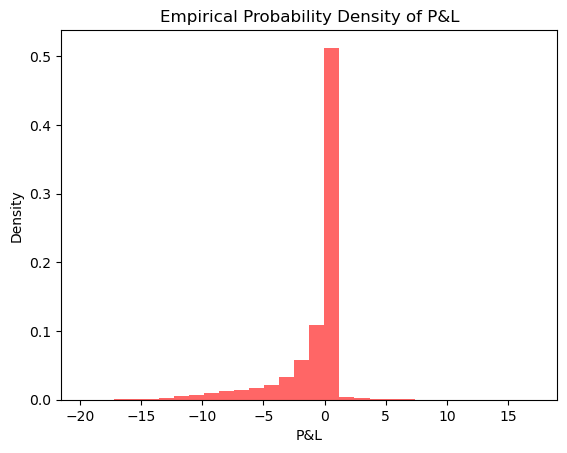

In [24]:
# Plot the histogram 'Empirical Probability Density of P&L'
plt.hist(relative_PnL800, bins=30, density=True, alpha=0.6, color='r')
plt.title('Empirical Probability Density of P&L')
plt.xlabel('P&L')
plt.ylabel('Density')
plt.show()